In [119]:
#导入需要的库
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
%matplotlib inline

In [120]:
#读取数据
aural = np.load(r'data/mod_aural.npy')
social = np.load(r'data/mod_social.npy')
textual = np.load(r'data/mod_textual.npy')
visual = np.load(r'data/mod_visual.npy')
train = np.load(r'data/train.npy')
#训练数据
aural_train = aural[:1600,:]
social_train = social[:1600,:]
textual_train = textual[:1600,:]
visual_train = visual[:1600,:]
#测试数据
aural_test = aural[1600:,:]
social_test = social[1600:,:]
textual_test = textual[1600:,:]
visual_test = visual[1600:,:]

In [121]:
#GPU
use_gpu = torch.cuda.is_available()

In [122]:
#精度
'''
nn.benchmark = False            # if benchmark=True, deterministic will be False
nn.deterministic = True
'''
seed = 1
torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed) 

random.seed(seed)
np.random.seed(seed)

In [123]:
#连接数据
linear_train = np.concatenate([aural_train, social_train,textual_train,visual_train], 1)
linear_test = np.concatenate([aural_test,social_test,textual_test,visual_test],1)


In [124]:
data = {'x':torch.from_numpy(linear_train),'y':torch.from_numpy(train)}
if (use_gpu):
    data['x'],data['y'] = data['x'].cuda(),data['y'].cuda()

In [125]:
class Residual_block(nn.Module):
    """
    Define Residual_block
    """
    def __init__(self, hidden_unit, dim_stack):
        super(Residual_block, self).__init__()
        # 两个线性层   注意维度， 输出的时候和输入的那个维度一致， 这样才能保证后面的相加
        self.linear1 = nn.Linear(dim_stack, hidden_unit)
        self.linear2 = nn.Linear(hidden_unit, dim_stack)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        orig_x = x.clone()
        x = self.linear1(x)
        x = self.linear2(x)
        outputs = self.relu(x + orig_x)       # 跳远链接
        return outputs

In [126]:
class DeepCrossing(nn.Module):
    
    def __init__(self, dim_stack, hidden_units=3, dropout=0., output_dim=1):
        """
        DeepCrossing：
            stack:stacking的结果
        """
        super(DeepCrossing, self).__init__()
        
        # 残差层
        self.res_layers = nn.ModuleList([
            Residual_block(unit, dim_stack) for unit in range(1,hidden_units+1)
        ])
        
        # dropout层
        self.res_dropout = nn.Dropout(dropout)
        
        # 线性层
        self.linear = nn.Linear(dim_stack, output_dim)
    
    def forward(self, x):
        r = x
        for res in self.res_layers:
            r = res(r)
        
        r = self.res_dropout(r)
        outputs =  nn.functional.sigmoid(self.linear(r))
        return outputs

In [127]:
#embedding
sociald3 =  social_train[:,2]
embed = nn.Embedding(1600,10)
embed_sociald3 = embed(torch.from_numpy(sociald3).long())

sociald3t = social_test[:,2]
embed = nn.Embedding(400,10)
embed_sociald3t = embed(torch.from_numpy(sociald3t).long())
print(embed_sociald3t.shape)

torch.Size([400, 10])


In [128]:
#stacking
stack=np.concatenate([aural_train, social_train[:,:1],embed_sociald3.detach().numpy(),textual_train,visual_train], 1)
stack=torch.from_numpy(stack)
test = np.concatenate([aural_test,social_test[:,:1],embed_sociald3t.detach().numpy(),textual_test,visual_test],1)

stack=torch.from_numpy(linear_train)

In [129]:
hidden_units = 6
dropout = 0.
learning_rate = .2
net = DeepCrossing(stack.shape[1],hidden_units,dropout)
optimizer = torch.optim.SGD(net.parameters(), learning_rate)
loss_func = torch.nn.MSELoss()
if(use_gpu):
    net = net.cuda()
    loss_func = loss_func.cuda()

In [130]:
iterate = 5000
if (use_gpu):
    stack = stack.cuda()
for t in range(iterate):
    prediction = net(stack)
    loss = loss_func(prediction, data['y'])     # must be (1. nn output, 2. target)
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    if(t%500 == 0):
        print(t,loss)

0 tensor(1.2054, device='cuda:0', grad_fn=<MseLossBackward>)
500 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
1000 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
1500 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
2000 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
2500 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
3000 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
3500 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
4000 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)
4500 tensor(1.0152, device='cuda:0', grad_fn=<MseLossBackward>)


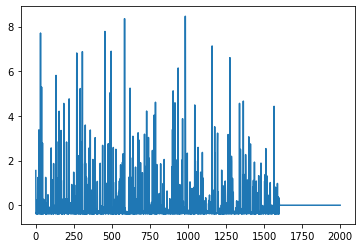

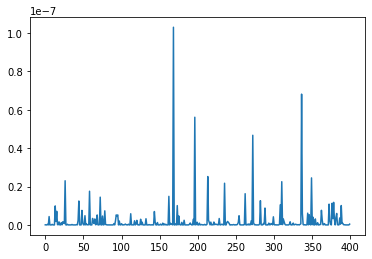

In [131]:
if(use_gpu):
    net = net.cpu()
predict = net(torch.from_numpy(linear_test))    
pre = predict.detach().numpy().flatten()
total = np.concatenate([train,pre])
x = range(total.shape[0])
y = total[x]
plt.plot(x,y)
plt.show()
x = range(pre.shape[0])
y = pre[x]
plt.plot(x,y)
plt.show()
np.save(r'prediction/DC_no_embed_re'+ str(hidden_units) +'_drop'+ str(dropout)+'_'+str(iterate)+'.npy',pre)

DC_embed_re3_drop0_500
1.0117058718703729	

DC_embed_re3_drop0_1000
1.0117058718703729	

DC_embed_re3_drop0_10000
1.0117063282335104	

DC_embed_re3_drop0.2_10000
1.0117308805703074	

DC_embed_re6_drop0.2_10000
1.0117059631430005	

DC_no_embed_re3_drop0_500
1.0117453929180795	

DC_no_embed_re3_drop0_1000
1.0117505041852195	

DC_no_embed_re3_drop0_10000
1.0129915381013086

DC_no_embed_re3_drop0.2_10000
1.0125542509429661	

DC_no_embed_re6_drop0_1000
1.0117059631430005	

DC_no_embed_re6_drop0_5000


DC_no_embed_re6_drop0_10000
1.0117061456882555	

DC_no_embed_re6_drop0.2_10000
1.0117059631430005

DC_no_embed_re6_drop0.3_10000
1.0117061456882555	